In [1]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf

In [3]:
meta = yf.Ticker('META').history(period='max')

In [4]:
meta.index

DatetimeIndex(['2012-05-18 00:00:00-04:00', '2012-05-21 00:00:00-04:00',
               '2012-05-22 00:00:00-04:00', '2012-05-23 00:00:00-04:00',
               '2012-05-24 00:00:00-04:00', '2012-05-25 00:00:00-04:00',
               '2012-05-29 00:00:00-04:00', '2012-05-30 00:00:00-04:00',
               '2012-05-31 00:00:00-04:00', '2012-06-01 00:00:00-04:00',
               ...
               '2023-07-21 00:00:00-04:00', '2023-07-24 00:00:00-04:00',
               '2023-07-25 00:00:00-04:00', '2023-07-26 00:00:00-04:00',
               '2023-07-27 00:00:00-04:00', '2023-07-28 00:00:00-04:00',
               '2023-07-31 00:00:00-04:00', '2023-08-01 00:00:00-04:00',
               '2023-08-02 00:00:00-04:00', '2023-08-03 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=2820, freq=None)

In [5]:
meta.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

<Axes: xlabel='Date'>

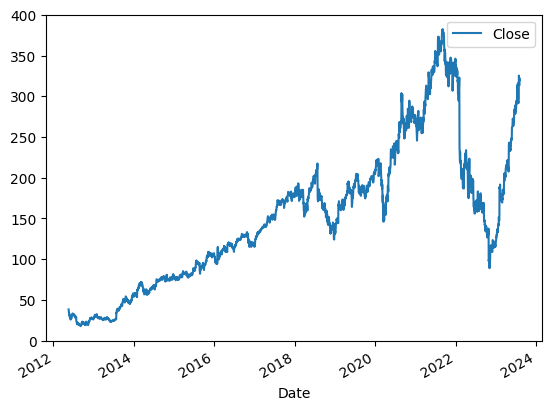

In [6]:
meta.plot.line(y="Close", use_index=True)

In [7]:
del meta["Dividends"]
del meta["Stock Splits"]

In [8]:
#Target prediction is: Will it go up or down?
meta['Tomorrow'] = meta['Close'].shift(-1)

In [9]:
meta['Target_Pred'] = (meta['Tomorrow'] > meta['Close']).astype(int)

In [10]:
meta = meta.loc['2000-01-01':].copy()

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=42)

train = meta.iloc[:-200]
test = meta.iloc[-200:]

predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
model.fit(train[predictors], train['Target_Pred'])

RandomForestClassifier(min_samples_split=100, random_state=42)

In [12]:
from sklearn.metrics import precision_score
import pandas as pd

preds = pd.Series(model.predict(test[predictors]), index=test.index)


In [13]:
precision_score(test['Target_Pred'], preds)

0.5555555555555556

In [14]:
combined = pd.concat([test["Target_Pred"], preds], axis=1)

<Axes: xlabel='Date'>

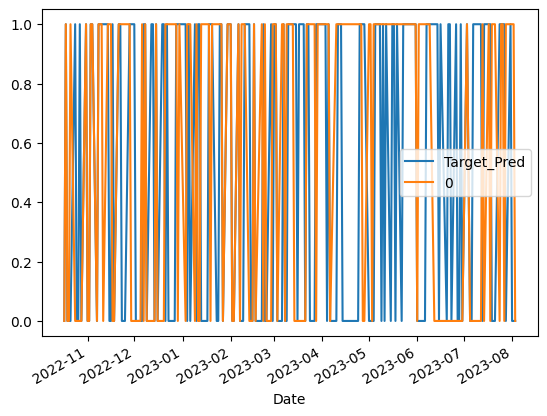

In [15]:
combined.plot()

In [16]:
#Build a more robust way to test against a longer period of times

#Back-testing

def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target_Pred'])
    preds = model.predict(test[predictors])
    preds = pd.Series(model.predict(test[predictors]), index=test.index, name="Predictions")
    combined = pd.concat([test["Target_Pred"], preds], axis=1)
    
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions =predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions) 

In [17]:
predictions = backtest(meta, model, predictors)

In [18]:
predictions["Predictions"].value_counts()

1    192
0    128
Name: Predictions, dtype: int64

In [19]:
precision_score(predictions['Target_Pred'], predictions['Predictions'])

0.5260416666666666

In [20]:
predictions['Target_Pred'].value_counts() / predictions.shape[0]

1    0.521875
0    0.478125
Name: Target_Pred, dtype: float64

In [21]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_avg = meta.rolling(horizon).mean()

    ratio_col = f"Close_Ratio_{horizon}"
    meta[ratio_col] = meta['Close'] / rolling_avg['Close']

    trend_col = f"Trend_{horizon}"
    meta[trend_col] = meta.shift(1).rolling(horizon).sum()['Target_Pred']

    new_predictors += [ratio_col, trend_col]

In [22]:
meta = meta.dropna()

In [23]:
meta

,Open,High,Low,Close,Volume,Tomorrow,Target_Pred,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2016-05-11 00:00:00-04:00,120.410004,121.080002,119.419998,119.519997,22038400,120.279999,1,0.995917,1.0,1.001743,2.0,1.071278,35.0,1.203875,139.0,1.922665,522.0
2016-05-12 00:00:00-04:00,119.980003,120.839996,118.900002,120.279999,22035500,119.809998,0,1.003169,1.0,1.003956,3.0,1.075667,35.0,1.209587,140.0,1.932210,523.0
2016-05-13 00:00:00-04:00,120.379997,120.639999,119.680000,119.809998,18124300,118.669998,0,0.998042,1.0,0.999499,2.0,1.068860,35.0,1.202977,139.0,1.921918,523.0
2016-05-16 00:00:00-04:00,119.379997,119.610001,117.349998,118.669998,31247800,117.349998,0,0.995220,0.0,0.990932,2.0,1.056475,34.0,1.189713,139.0,1.900988,522.0
2016-05-17 00:00:00-04:00,118.820000,119.010002,117.199997,117.349998,21328600,117.650002,1,0.994407,0.0,0.985091,1.0,1.043147,33.0,1.174746,139.0,1.877307,521.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27 00:00:00-04:00,325.119995,325.350006,309.839996,311.709991,64229200,325.480011,1,1.021531,2.0,1.045572,3.0,1.144041,35.0,1.699267,131.0,1.319682,522.0
2023-07-28 00:00:00-04:00,316.880005,326.200012,314.250000,325.480011,39220300,318.600006,0,1.021611,2.0,1.069363,4.0,1.188311,36.0,1.767919,132.0,1.377161,522.0
2023-07-31 00:00:00-04:00,323.690002,325.660004,317.589996,318.600006,25799600,322.709991,1,0.989318,1.0,1.028518,4.0,1.157448,36.0,1.724603,131.0,1.347319,521.0


In [24]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=42)

In [25]:

def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target_Pred'])
    preds = model.predict(test[predictors])[:, 1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(model.predict(test[predictors]), index=test.index, name="Predictions")
    combined = pd.concat([test["Target_Pred"], preds], axis=1)
    
    return combined

In [26]:
predictions = backtest(meta, model, new_predictors)

ValueError: No objects to concatenate